In [ ]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets


2.5.0


In [ ]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFXWNR9/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFXWNR9/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFXWNR9/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

**Model 1: Only Using Embeddings**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 71s 85ms/step - loss: 0.5048 - accuracy: 0.7297 - val_loss: 0.3589 - val_accuracy: 0.8382
Epoch 2/50
782/782 [==============================] - 65s 83ms/step - loss: 0.2951 - accuracy: 0.8800 - 

AttributeError: ignored

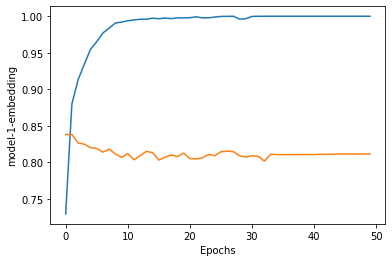

In [ ]:
# #vocab_size = 10000
# embedding_dim = 16
# max_length = 120

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel("model-1-embedding" + string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

My model will look like this, with a 171,533 parameters, and the performance will be like this. It's nice accuracy, but clear overfitting but it only takes about five seconds per epoch to train.

**MODEL 2: WITH BIDERCTIONAL LSTM**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel("model-2-LSTM" + string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

If I change this to use an LSTM, I'll now have only 30,129 parameters, but it will take about 43 seconds per epoch. The accuracy is better, but there's still some overfitting. 

**MODEL 3: USING GATED RECURRENT UNIT(GRU)**

To solve the Vanishing-Exploding gradients problem often encountered during the operation of a basic Recurrent Neural Network, many variations were developed. One of the most famous variations is the Long Short Term Memory Network(LSTM). One of the lesser known but equally effective variations is the Gated Recurrent Unit Network(GRU). 

Unlike LSTM, it consists of only three gates and does not maintain an Internal Cell State.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
782/782 [==============================] - 17s 19ms/step - loss: 0.5149 - accuracy: 0.7210 - val_loss: 0.3623 - val_accuracy: 0.8410
Epoch 2/20
782/782 [==============================] - 13s 17ms/step - loss: 0.3025 - accuracy: 0.8756 

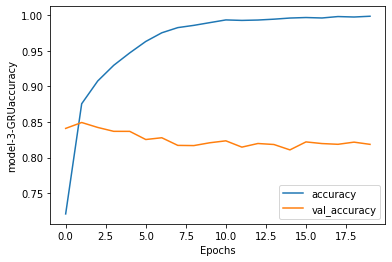

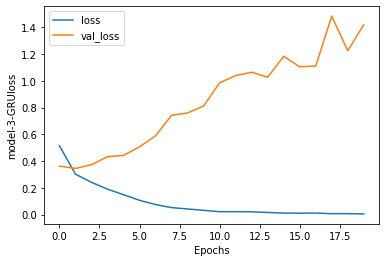

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel("model-3-GRU" + string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

 If I try a GRU layer instead, with a GRU being a different type of RNN, and I make it bidirectional, my network will have a 169,997 parameters. My training time will fall to 20 seconds per epoch, and my accuracy is again very good on training, and not too bad on validation but again, showing some overfitting.

Model 4: Using Convolutional Neural Networks:


In [ ]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel("model-4-CNN" + string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

With a convolutional network, I'll have a 171,149 parameters and it only takes about six seconds per epoch to get me close to 100 percent accuracy on training, and about 83 percent on validation, but again with overfitting.